## MNIST Classifier

### Frame the problem

4. This particular Problem is unsupervised, and offline.
5. The prompt is to measure performance with accuracy.
7. The minimum accuracy is 97%

### Get the data

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
import numpy as np
import scipy

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"].astype(np.int32)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
%%time

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

CPU times: user 34.2 s, sys: 253 ms, total: 34.5 s
Wall time: 34.5 s


RandomForestClassifier(random_state=42)

In [6]:
%%time

y_test_pred = rfc.predict(X_test)
accuracy_score(y_test, y_test_pred)

CPU times: user 327 ms, sys: 33.1 ms, total: 360 ms
Wall time: 358 ms


0.9705

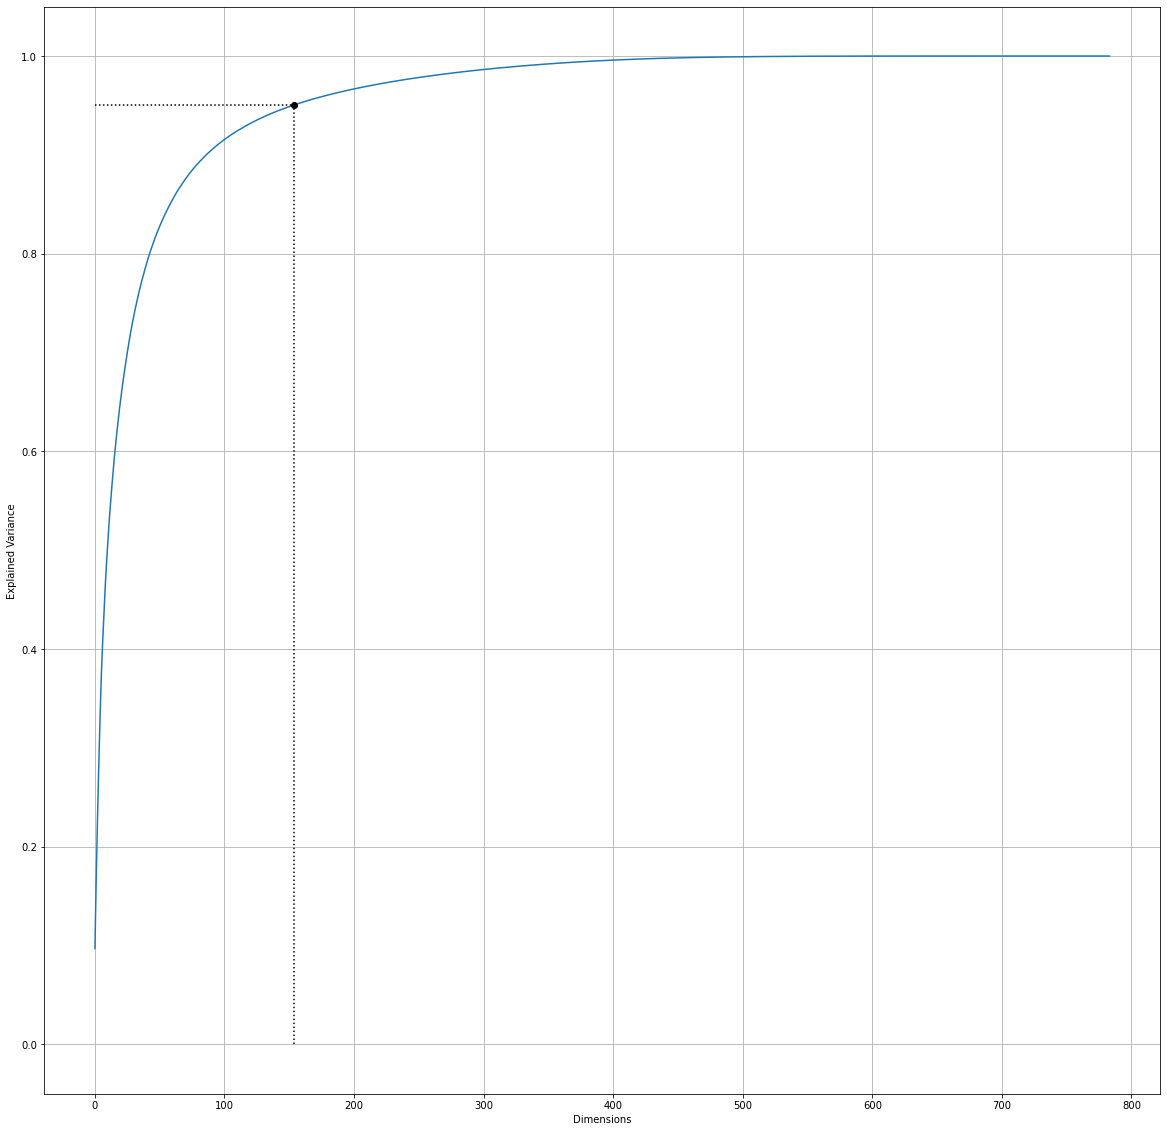

In [7]:
# this cell is mostly copied from https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb

exploratory_pca = PCA()
exploratory_pca.fit(X_train)

cumsum = np.cumsum(exploratory_pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(list(i for i in range(len(cumsum))), cumsum)
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.grid(True)

In [8]:
%%time

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

CPU times: user 12.5 s, sys: 704 ms, total: 13.2 s
Wall time: 4.06 s


In [9]:
%%time

X_test_reduced = pca.transform(X_test)

CPU times: user 121 ms, sys: 19.7 ms, total: 141 ms
Wall time: 61.4 ms


In [10]:
%%time

rfc_reduced = RandomForestClassifier(random_state=42)
rfc_reduced.fit(X_train_reduced, y_train)

CPU times: user 1min 24s, sys: 241 ms, total: 1min 24s
Wall time: 1min 24s


RandomForestClassifier(random_state=42)

 So interestingly training took 3x longer.

In [11]:
%%time

y_test_reduced_pred = rfc_reduced.predict(X_test_reduced)
accuracy_score(y_test, y_test_reduced_pred)

CPU times: user 277 ms, sys: 24.4 ms, total: 301 ms
Wall time: 300 ms


0.9481

Following https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb, I'll now try logistic regression.

In [12]:
%%time

lrc = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
lrc.fit(X_train, y_train)

CPU times: user 34 s, sys: 487 ms, total: 34.5 s
Wall time: 9.22 s


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=42)

In [13]:
%%time

y_test_pred = lrc.predict(X_test)
accuracy_score(y_test, y_test)

CPU times: user 68.2 ms, sys: 4.38 ms, total: 72.6 ms
Wall time: 20.9 ms


1.0

In [14]:
%%time

lrc.fit(X_train_reduced, y_train)

CPU times: user 12.9 s, sys: 379 ms, total: 13.2 s
Wall time: 3.32 s


/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=42)

So logistic regression sees a 3x speedup from PCA.

In [15]:
%%time

y_test_reduced_pred = lrc.predict(X_test_reduced)
accuracy_score(y_test, y_test_reduced_pred)

CPU times: user 15.1 ms, sys: 2.65 ms, total: 17.7 ms
Wall time: 3.98 ms


0.9201

Prediction time is 15 ms for full dimensionality vs 4 ms for reduced, but this time is negligible overall.

In [16]:
def plot_2d_classes(X, y, classes, title):
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    for c in classes:
        X_cls = X[y == c]
        plt.scatter(X_cls[:, 0], X_cls[:, 1], marker=f"${c}$")

In [17]:
def plot_3d_classes(X, y, classes, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    for c in classes:
        X_cls = X[y == c]
        ax.scatter(X_cls[:, 0], X_cls[:, 1], X_cls[:, 2], marker=f"${c}$")

In [18]:
idx = np.random.choice(np.arange(len(X_train)), 1000, replace=False)
X_train_sample = X_train[idx]
y_train_sample = y_train[idx]

## Visualizations

Overall takeaways (specific to MNIST data, but these takeaways probably generalize to some extent):
- tSNE produces by far the most interpretable and pattern-rich visualizations.
- the 3d visualizations don't really add much over the 2d visualizations.

### tSNE

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 31.7 s, sys: 2.87 s, total: 34.6 s
Wall time: 4.91 s


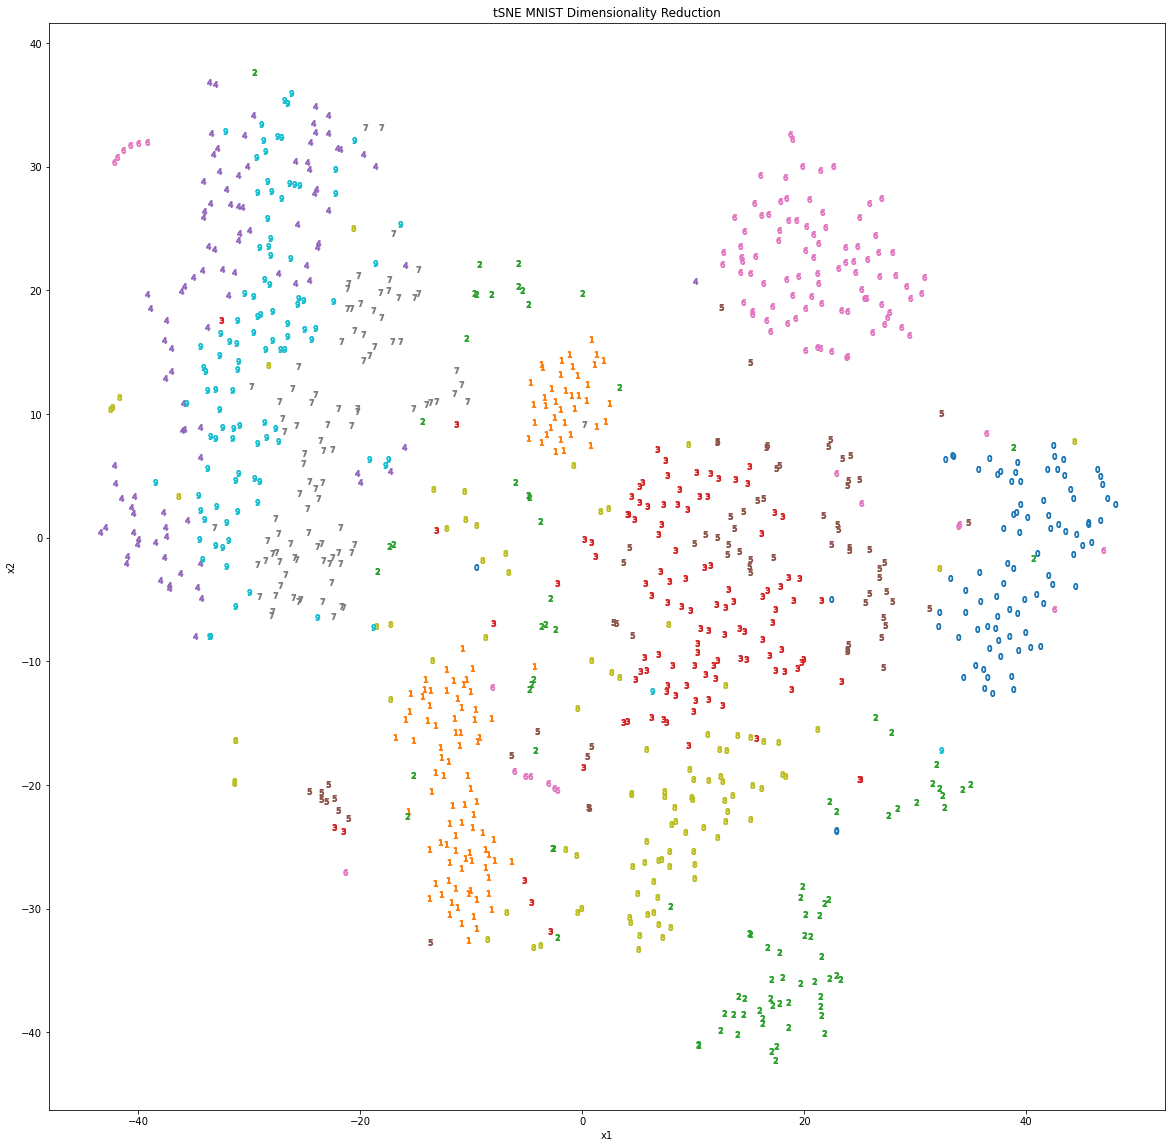

In [19]:
%%time

tsne = TSNE()
X_train_sample_reduced = tsne.fit_transform(X_train_sample)
plot_2d_classes(X_train_sample_reduced, y_train_sample, (i for i in range(10)), "tSNE MNIST Dimensionality Reduction")

/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/handson/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 1min 2s, sys: 3.4 s, total: 1min 6s
Wall time: 9.03 s


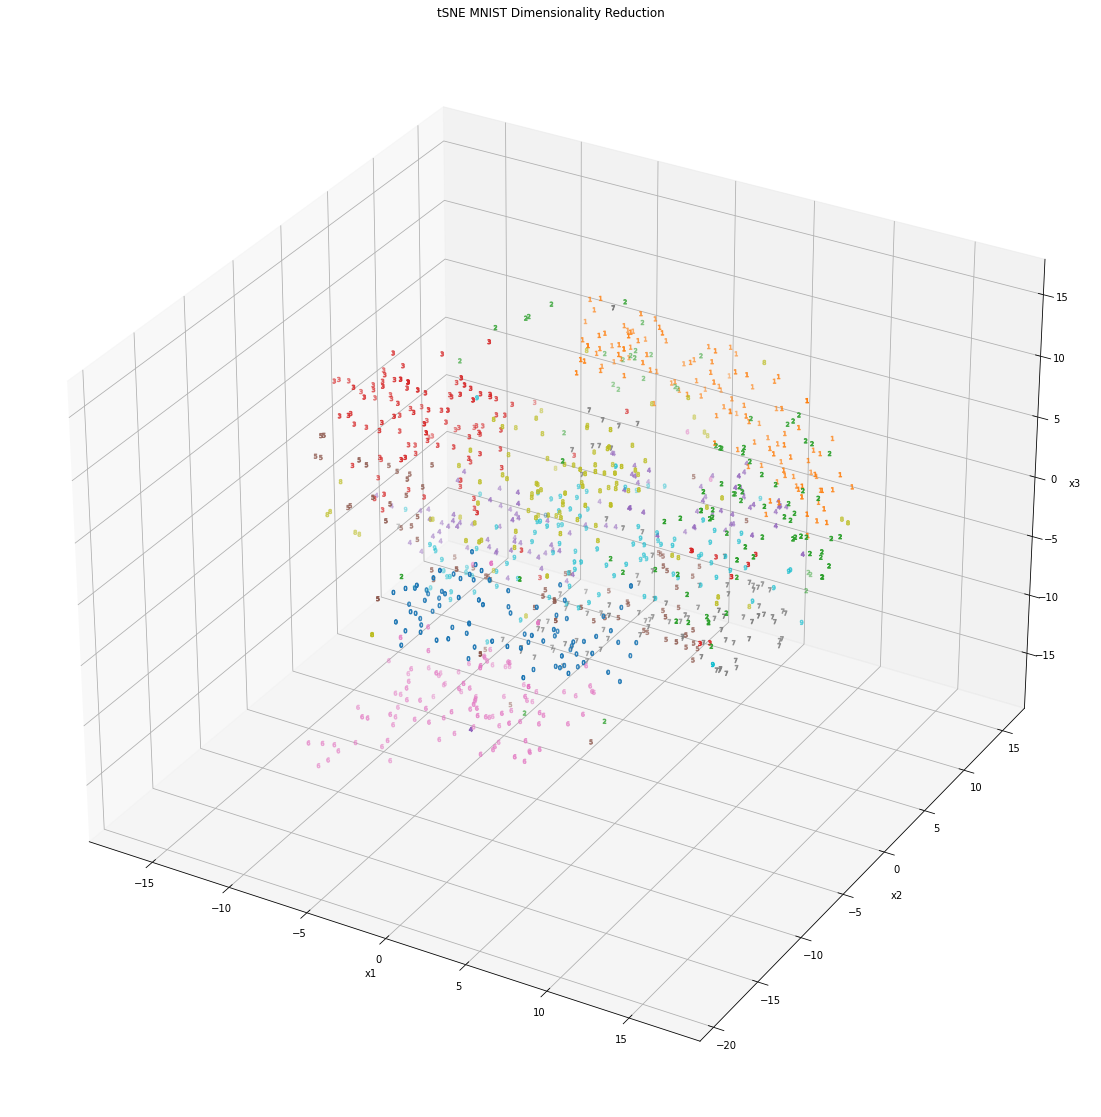

In [20]:
%%time

tsne_3d = TSNE(n_components=3)

X_train_sample_reduced = tsne_3d.fit_transform(X_train_sample)

plot_3d_classes(X_train_sample_reduced, y_train_sample, (i for i in range(10)), "tSNE MNIST Dimensionality Reduction")

### PCA

These visualizations are not nearly as interpretable as tSNE. The classes are interspersed with only a few obvious patterns, like the ones being clustered. The classes tend to have neighborhoods, but they overlap each other.

CPU times: user 201 ms, sys: 12.6 ms, total: 214 ms
Wall time: 58.6 ms


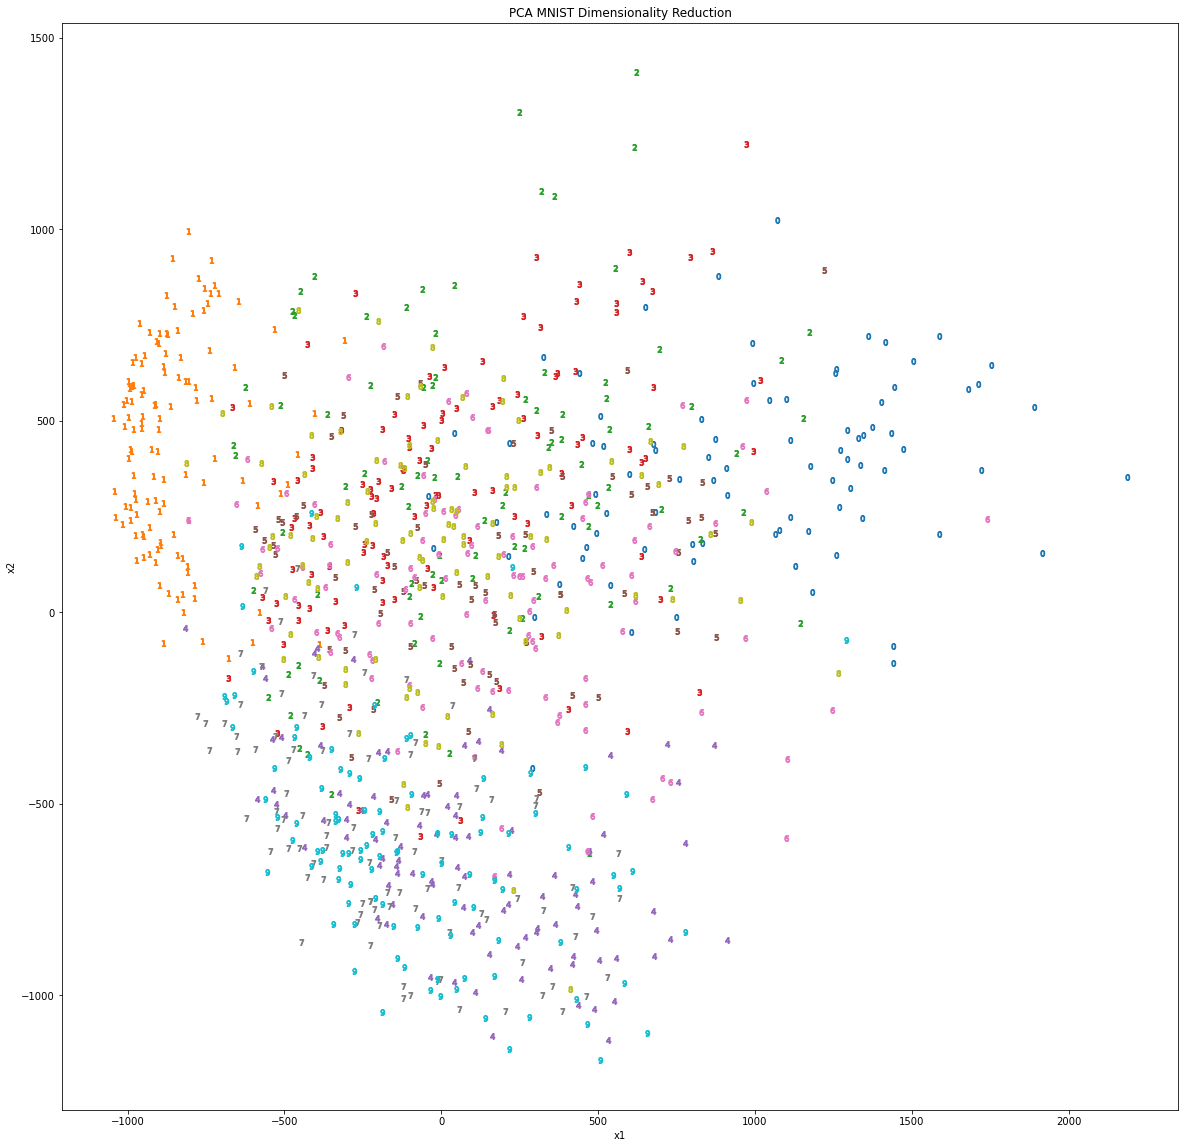

In [21]:
%%time

pca_2d = PCA(n_components=2)
X_train_sample_reduced = pca_2d.fit_transform(X_train_sample)
plot_2d_classes(X_train_sample_reduced, y_train_sample, (i for i in range(10)), "PCA MNIST Dimensionality Reduction")

CPU times: user 179 ms, sys: 9.86 ms, total: 189 ms
Wall time: 50 ms


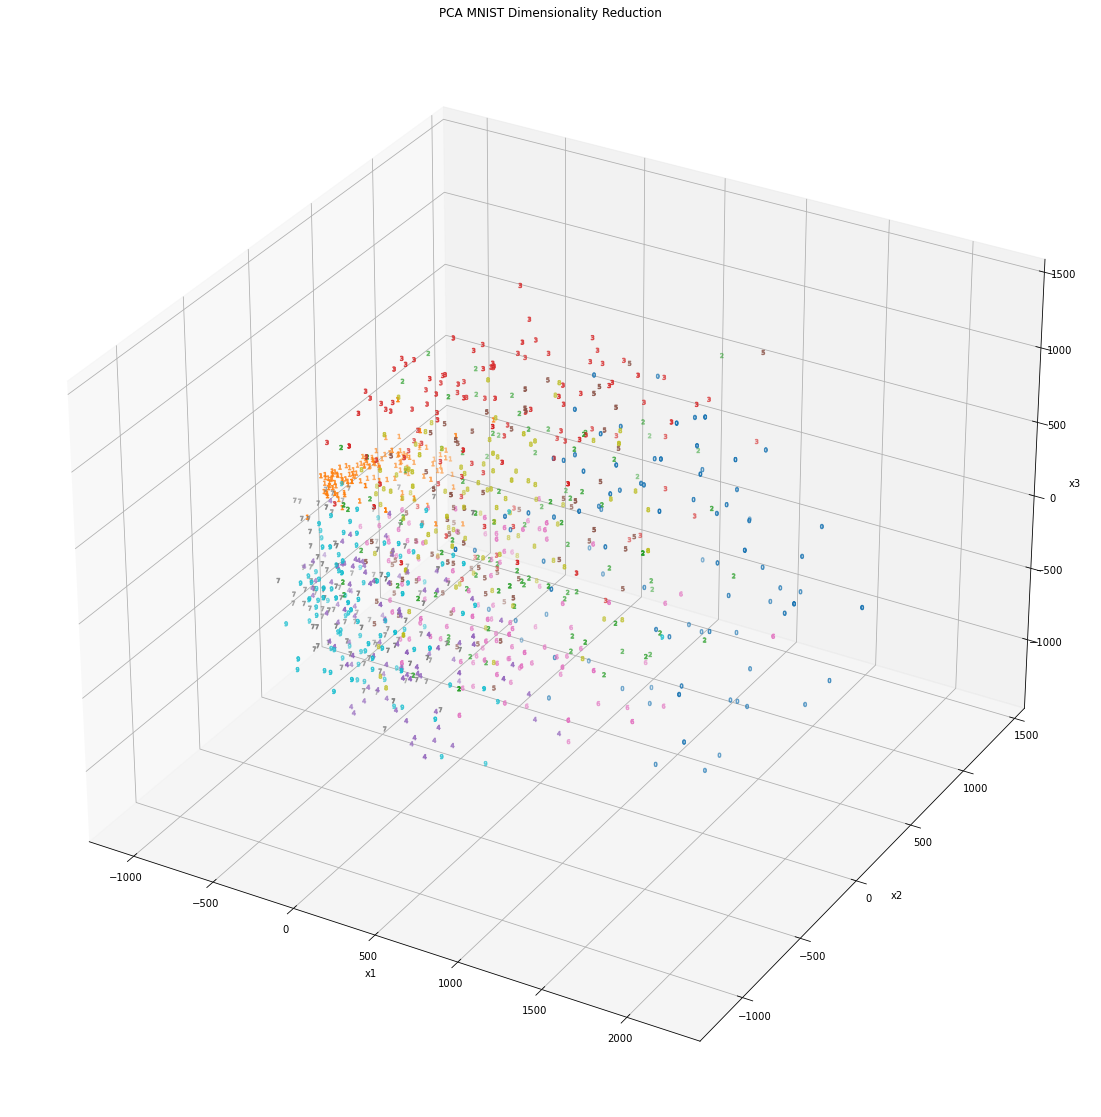

In [22]:
%%time

pca_3d = PCA(n_components=3)
X_train_sample_reduced = pca_3d.fit_transform(X_train_sample)
plot_3d_classes(X_train_sample_reduced, y_train_sample, (i for i in range(10)), "PCA MNIST Dimensionality Reduction")

### Locally Linear Embedding

Really interesting how the zeros and ones form a very obvious straight line while the rest of the classes are concentrated in a "nucleus".

CPU times: user 879 ms, sys: 41 ms, total: 920 ms
Wall time: 235 ms


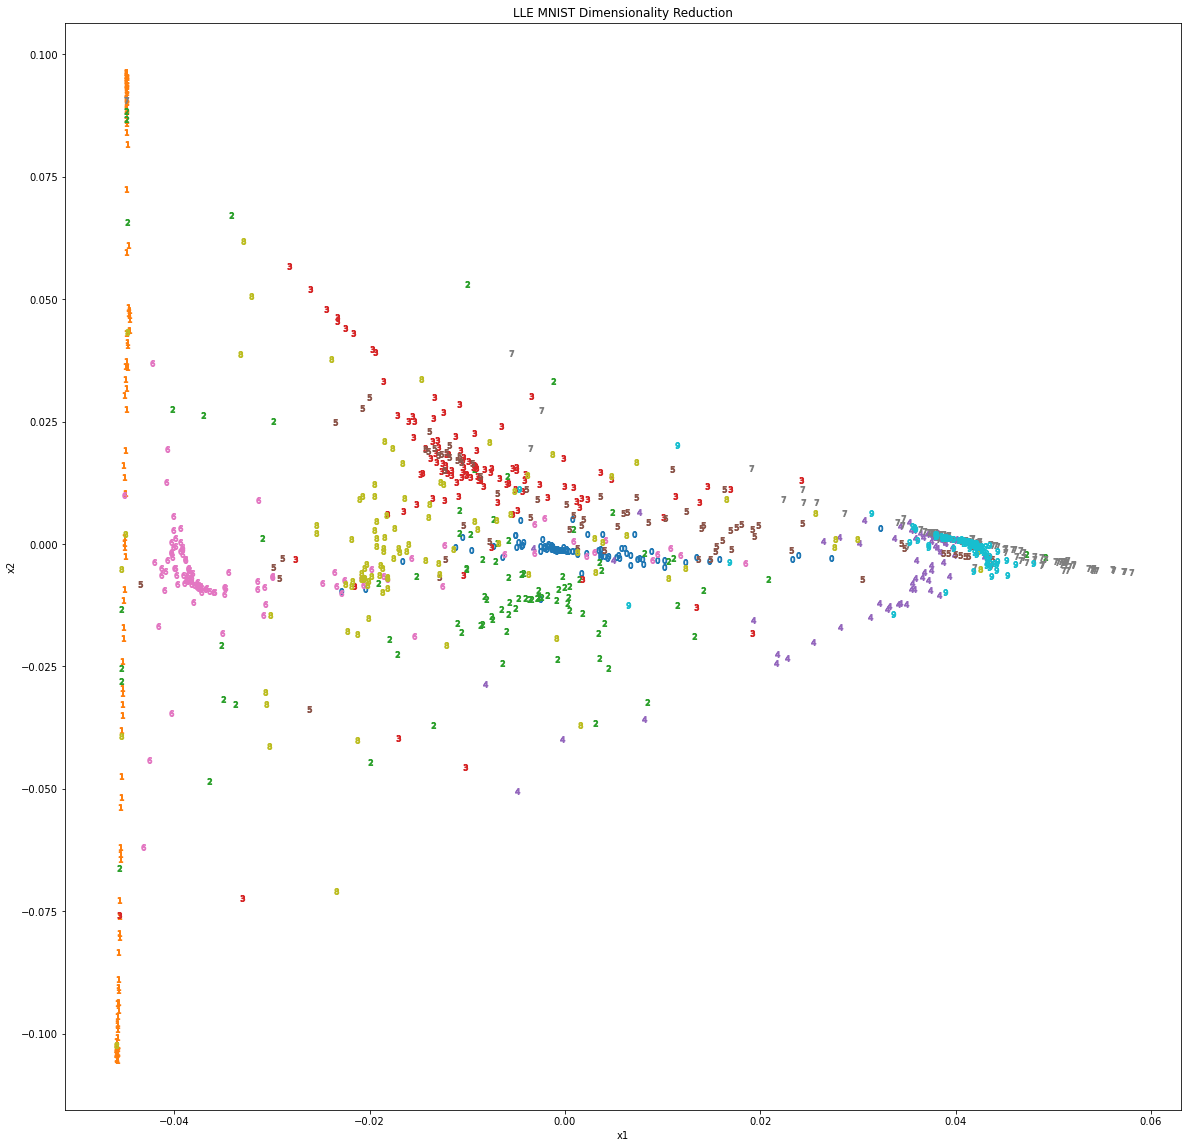

In [23]:
%%time

lle_2d = LocallyLinearEmbedding(n_components=2)
X_train_sample_reduced = lle_2d.fit_transform(X_train_sample)
plot_2d_classes(X_train_sample_reduced, y_train_sample, (i for i in range(10)), "LLE MNIST Dimensionality Reduction")

CPU times: user 802 ms, sys: 25.6 ms, total: 828 ms
Wall time: 211 ms


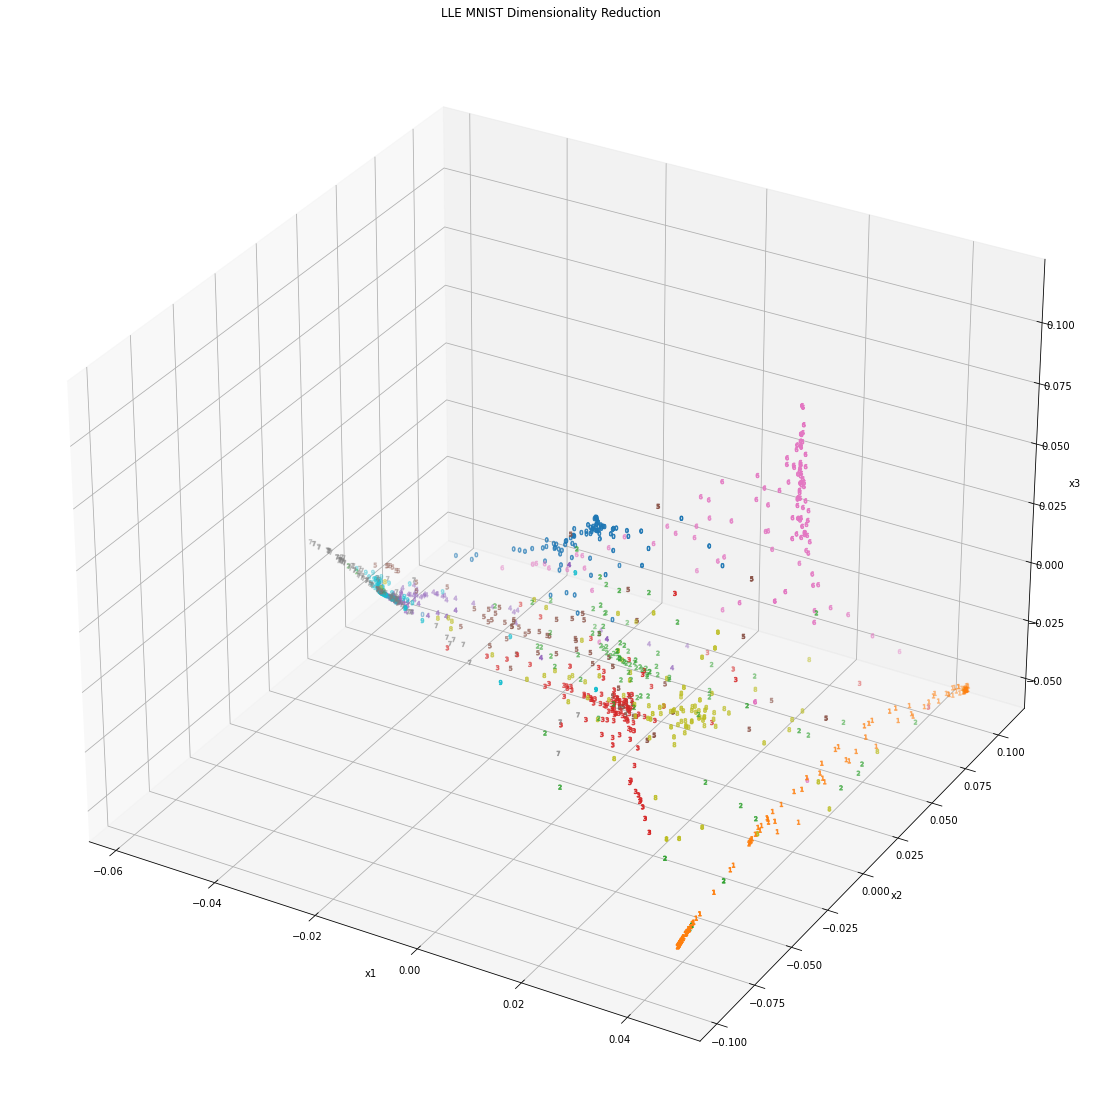

In [24]:
%%time

lle_3d = LocallyLinearEmbedding(n_components=3)
X_train_sample_reduced = lle_3d.fit_transform(X_train_sample)
plot_3d_classes(X_train_sample_reduced, y_train_sample, (i for i in range(10)), "LLE MNIST Dimensionality Reduction")

### Multidimensional Scaling

MDS takes considerably longer to fit_transform in terms of wall clock time than the other models, and seems to produce poor clusters overall. The ones seem to be clustered, but the zeros are notably spread across the entire image. Interesting how the zeros form a line in LLE, and seem to have large, isotropic variance in MDS.

CPU times: user 1min 11s, sys: 3.8 s, total: 1min 15s
Wall time: 19 s


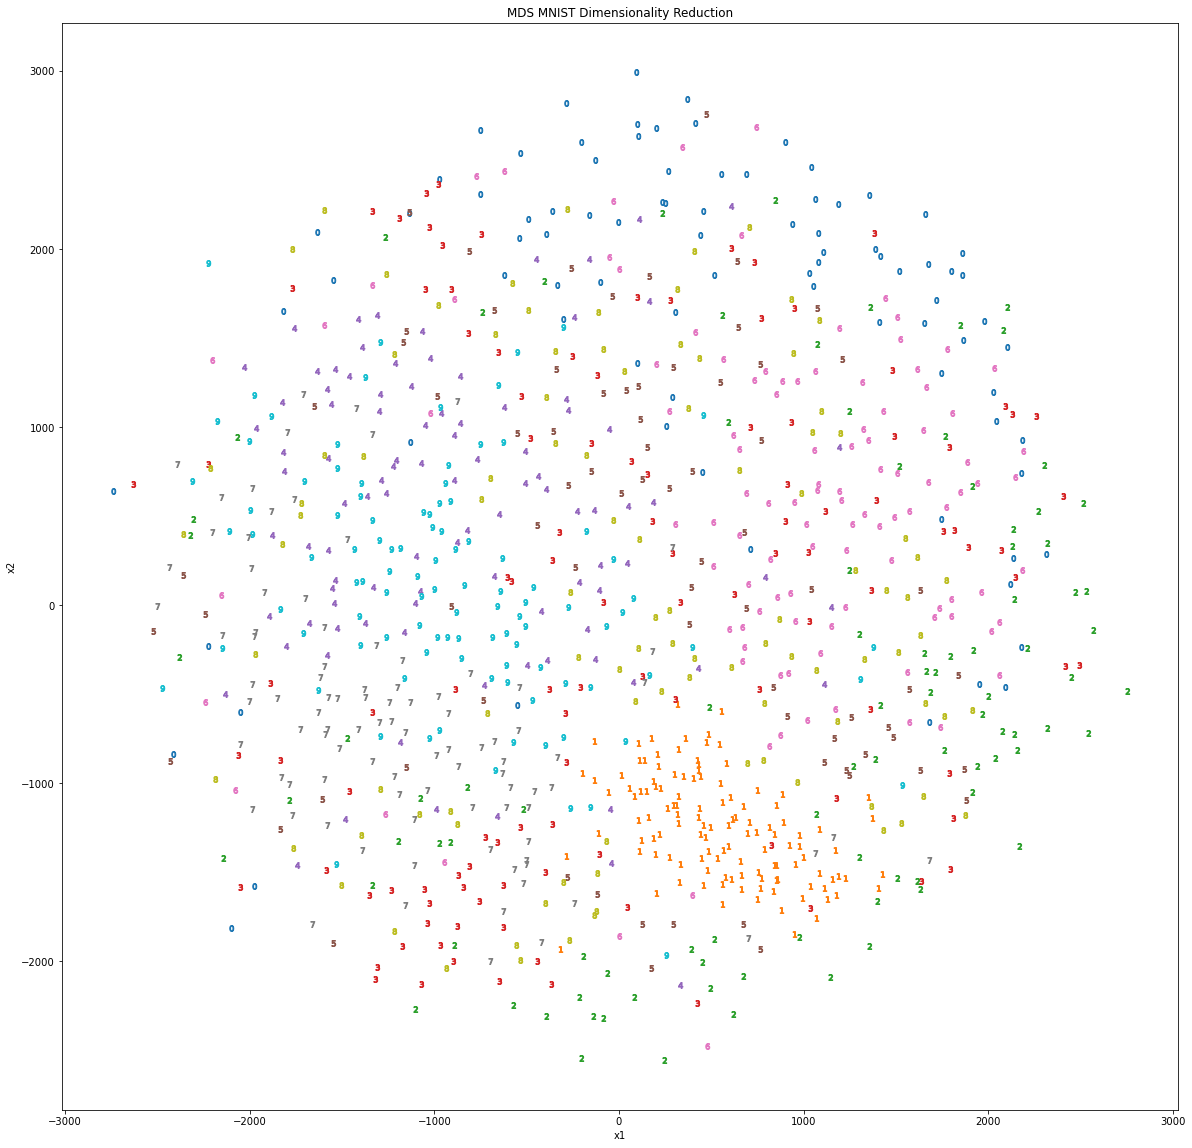

In [25]:
%%time

mds_2d = MDS(n_components=2)
X_train_sample_reduced = mds_2d.fit_transform(X_train_sample)
plot_2d_classes(X_train_sample_reduced, y_train_sample, (i for i in range(10)), "MDS MNIST Dimensionality Reduction")

CPU times: user 1min 8s, sys: 2.66 s, total: 1min 10s
Wall time: 17.8 s


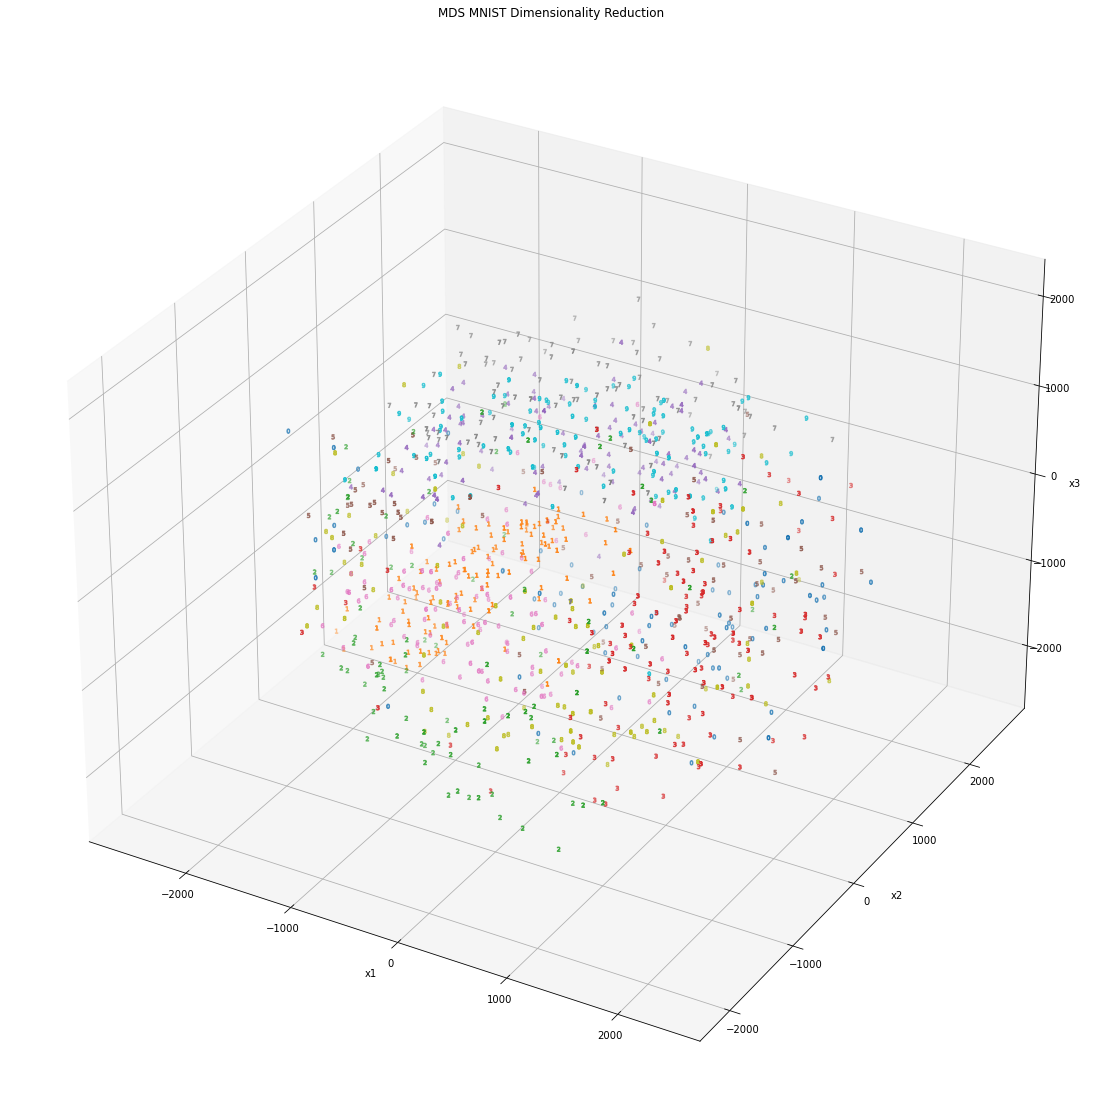

In [26]:
%%time

mds_3d = MDS(n_components=3)
X_train_sample_reduced = mds_3d.fit_transform(X_train_sample)
plot_3d_classes(X_train_sample_reduced, y_train_sample, (i for i in range(10)), "MDS MNIST Dimensionality Reduction")